# Q-learning Snake Game - Surya Sunkari

<img src="snake_game.jpg" width="300"/>

#### Imports

In [1]:
# you will need pygame installed
!pip install pygame

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
    --------------------------------------- 0.2/10.8 MB 3.7 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/10.8 MB 10.8 MB/s eta 0:00:01
   --------- ------------------------------ 2.7/10.8 MB 19.0 MB/s eta 0:00:01
   ------------------ --------------------- 4.9/10.8 MB 26.1 MB/s eta 0:00:01
   ------------------ --------------------- 5.1/10.8 MB 26.9 MB/s eta 0:00:01
   ---------------------------- ----------- 7.7/10.8 MB 27.5 MB/s eta 0:00:01
   ------------------------------------- -- 10.2/10.8 MB 32.5 MB/s eta 0:00:01
   ---------------------------------------- 10.8/10.8 MB 36.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import pygame
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import itertools

# the environment is provided in game_loop.py
from game_loop import *

### Game States
For Q-Learning, the agent needs to keep a Q-Table of game states. To keep the number of possible game states manageable, we will define the game state as a combination of:
* Horizontal orientation from the food - is the food currently to the left or the right of the snake's head? (-1: left, 0: same, 1: right)
* Vertical orientation from the food - is the food currently above or below the snake's head? (-1: below, 0: same, 1: above) 
* What are in the squares adjacent to the snake's head - are there walls or snake tail in these squares? (1 indicates something is there, 0 indicates it is open)

The environment (which is in the provided `game_loop.py` file) will provide this state in the form of two tuples:
- The first tuple will contain (relative horizontal orientation to food, relative vertical orientation to food).
- The second tuple will contain the squares surrounding the snake's head in the form of (up, down, left, right) where a 1 indicates wall or tail is in that square and 0 indicates that square is open.

### Snake Agent
Below is the class for the SnakeAgent that will learn to play the game, using Q-Learning. 

Here is a description of the methods:
* `__init__`: The constructor sets up some constants and sets the learning parameter values. It also calls init_qtable to initialize the Q-Table. 
* `init_qtable`: Initializes the Q-Table. The `qtable` is implemented as a dictionary of state -> list of four Q-Values, representing the four action choices of [left, right, up, down].
* `save` and `load`: Saves the Q-Values (via pickle) so the agent can be re-loaded later via load.

These methods will be called by the `game_loop.py` file:
* `act`: This method is responsible for selecting an action based on the current state.
* `update`: This where the Q-values get updated based on the agent's actions and rewards during gameplay.


In [9]:
class SnakeAgent(object):

    def __init__(self, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE):

        self.ACTION_STRING_MAP = {0: "left", 1: "right", 2: "up", 3: "down"}

        # Learning parameters
        self.epsilon = 0.1 # exploration rate
        self.alpha = 0.4 # learning rate
        self.gamma = 0.5 # discount factor

        # Initialize the Q-Table
        self.init_qtable()
        
        # State/Action history
        self.curr_state = None
        self.curr_act = None
        self.curr_dist_from_food = 1000

    def init_qtable(self):
        # Initialize the qtable to all 0s
        self.qtable = {}
        REL_Y = [-1, 0, 1] # [below, same, above]
        REL_X = [-1, 0, 1] # [left, same, right]
        SURROUNDINGS = list(itertools.product(*[[0,1]] * 4)) # [0, 1] possibilities for surrounding block in each direction
        for y in REL_X:
            for x in REL_Y:
                for s in SURROUNDINGS:
                    self.qtable[QState((x, y), tuple(s))] = [0, 0, 0, 0] # q values for actions [left, right, up, down]

    def load(self, path="qtable.pkl"):
        return pkl.load(open(path, "rb"))

    def save(self, path="qtable.pkl"):
        pkl.dump(self.qtable, open(path, "wb"))
        
    def act(self, state):
        selected_action = -1
        rand_value = random.random()
        if rand_value < self.epsilon:
            selected_action = random.choice([0, 1, 2, 3])
        else:
            potential_actions = self.qtable[state]
            selected_action = np.argmax(potential_actions)
        
        self.curr_state = state
        self.curr_act = selected_action
                   
        return self.ACTION_STRING_MAP[selected_action]
    
    def update(self, game_over, dist_from_food, new_state): 
        reward = 0
        if game_over:
            reward = -25
        else:
            if dist_from_food < self.curr_dist_from_food:
                reward = 10
            else:
                reward = -10
        self.curr_dist_from_food = dist_from_food
        
        old_q_val = self.qtable[self.curr_state][self.curr_act]
        td = reward + self.gamma * np.max(self.qtable[new_state]) - old_q_val
        new_q_val = old_q_val + self.alpha * td
        
        self.qtable[self.curr_state][self.curr_act] = new_q_val

### Game Loop
The code in this cell will kick off the game, using the SnakeAgent, and will let the agent play for the specified number of episodes (300), keeping track of the scores as the agent learns how to play. 

In [14]:
pygame.init()

BLOCK_SIZE = 10 
DIS_WIDTH = 600
DIS_HEIGHT = 500
FRAMESPEED = 50000 # extremely fast frame speed for training purposes.
NUM_EPISODES = 300

#create a SnakeAgent
agent = SnakeAgent(DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE)

game_count = 1
max_score = 0
scores = []

# loop for specified number of episodes
for i in range(NUM_EPISODES):
    # use an exponentially decaying epsilon rate
    if game_count > 100:
        agent.epsilon = max(.003, agent.epsilon * .98)
    else:
        agent.epsilon = .1
        
    # Start the game
    # (To turn off the game visualizations, you can set draw=False)
    score = GameLoop(agent, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, FRAMESPEED, draw=True)
    
    scores.append(score)
    max_score = max(max_score, score)
    print(f"Games: {game_count}; Score: {score}; Max Score: {max_score}") # Output results of each game to console to monitor as agent is training
    game_count += 1

agent.save()
print("Save Qvals")
pygame.quit()

Games: 1; Score: 1; Max Score: 1
Games: 2; Score: 1; Max Score: 1
Games: 3; Score: 1; Max Score: 1
Games: 4; Score: 1; Max Score: 1
Games: 5; Score: 1; Max Score: 1
Games: 6; Score: 1; Max Score: 1
Games: 7; Score: 1; Max Score: 1
Games: 8; Score: 1; Max Score: 1
Games: 9; Score: 1; Max Score: 1
Games: 10; Score: 1; Max Score: 1
Games: 11; Score: 1; Max Score: 1
Games: 12; Score: 1; Max Score: 1
Games: 13; Score: 1; Max Score: 1
Games: 14; Score: 1; Max Score: 1
Games: 15; Score: 1; Max Score: 1
Games: 16; Score: 1; Max Score: 1
Games: 17; Score: 1; Max Score: 1
Games: 18; Score: 1; Max Score: 1
Games: 19; Score: 2; Max Score: 2
Games: 20; Score: 1; Max Score: 2
Games: 21; Score: 1; Max Score: 2
Games: 22; Score: 1; Max Score: 2
Games: 23; Score: 1; Max Score: 2
Games: 24; Score: 2; Max Score: 2
Games: 25; Score: 2; Max Score: 2
Games: 26; Score: 1; Max Score: 2
Games: 27; Score: 1; Max Score: 2
Games: 28; Score: 1; Max Score: 2
Games: 29; Score: 2; Max Score: 2
Games: 30; Score: 1; Ma

#### Graphing the progression of the agent's score

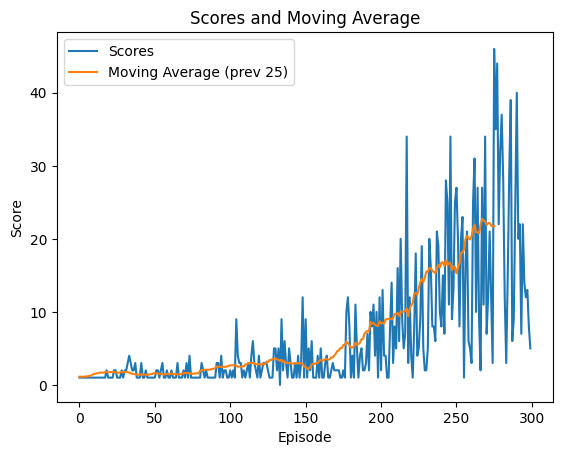

In [19]:

# Plot the scores
plt.plot(scores, label='Scores')

# Calculate the moving average
window_size = 25
moving_avg = [sum(scores[i:i+window_size])/window_size for i in range(len(scores)-window_size+1)]

# Plot the moving average
plt.plot(moving_avg, label='Moving Average (prev 25)')

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores and Moving Average')

# Add legend
plt.legend()

# Show the plot
plt.show()


#### Saving and loading the trained agent
The code above above saves your trained agent as a pkl file. You can use the cell below to load your trained agent and run it (so you don't have to re-train it).

In [33]:
agent.load()
pygame.init()
FRAMESPEED = 100 # slower frame speed for visualization
GameLoop(agent, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, FRAMESPEED, draw=True)
pygame.quit()